# 处理文本数据
1)文本向量化
* one-hot编码：将每个单词与唯一的整数索引i相关联，然后转化为二进制向量，第i个元素为1，是稀疏的。
* 词嵌入: 得到低维的浮点数向量，是密集的。
 * 完成主任务的同时学习
 * 预训练词嵌入
 
 * 利用Embedding层学习词嵌入 
   * 该层需要两个参数，标记的个数、嵌入的维度
   * 输入为一个二维张量（samples，sequence_length）   (32,10)表示32个长度为10的序列组成的批量
   * 输出为三维浮点数向量(samples, sequence_length, embedding_dimensionality)可以输入RNN或者一维卷基层处理
   * 

### 用keras实现单词级的one-hot编码

In [19]:
from keras.preprocessing.text import Tokenizer

samples = ['Hello, my name is liu', 'I love my friends.']

# 创建一个分词器，设置为只考虑前1000个常见的单词
tokenizer = Tokenizer(num_words=1000)
# 构建单词索引
tokenizer.fit_on_texts(samples)

# 将字符串转换为整数索引组成的列表
sequences = tokenizer.texts_to_sequences(samples)

# 也可以直接得到one-hot二进制表示，该分词器也支持除one-hot编码外的其他向量化模式
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# 找回单词索引
word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

Found 8 unique tokens.


### 单词级的one_hot编码

In [20]:
import numpy as np

# 初始数据：每个样本是列表的一个元素
samples = ['Hello, my name is liu', 'I love my friends.']

# 构建数据中的所有标记的索引
token_index={}
for sample in samples:
    # 用split方法对样本进行分词。实际应用中还需要从样本去掉标点和特殊字符，但keras提供的方法可以自东剔除
    for word in sample.split():
        if word not in token_index:
            # 为每一个唯一单词指定唯一索引。从1开始的
            token_index[word] = len(token_index)+1
            
max_length = 10

results = np.zeros(shape=(len(samples),
                          max_length, # 对样本分词，只考虑每个样本的前max_length个单词
                          max(token_index.values()) + 1))

for i,sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

### 字符级的one-hot编码

In [21]:
import string 

samples = ['Hello, my name is liu', 'I love my friends.']
# 所有可打印的ASCII字符
characters = string.printable
token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index]

## 词嵌入
* 在完成主任务的同时学习词嵌入-一开始是随机的词向量，然后进行学习，方式与学习神经网络的权重相同
* 预训练词嵌入

### 1、利用Embedding层学习词嵌入

In [22]:
from keras.layers import Embedding

# 该层至少需要两个参数:标记的个数，嵌入的维度
embedding_layer = Embedding(1000, 64)

In [65]:
from keras.datasets import imdb
from keras import preprocessing

# 将电影评论限制为前10000个最常见的单词
max_features = 10000

# 评论长度限制为100
maxlen = 100

# 将数据加载为整数列表
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 将整数列表转换为形状为（samples， maxlen）的二维整数张量
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### 在IMDB数据上使用Embedding层和分类器

In [32]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# 指定最大输入长度
model.add(Embedding(10000, 8, input_length=maxlen))

# 将三维的嵌入张量展平为形状(samples, maxlen*8)的二维张量
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 8)             80000     
_________________________________________________________________
flatten_9 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


/home/wukong/anaconda3/envs/deeplearning/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 52us/step - loss: 0.6623 - acc: 0.6299 - val_loss: 0.6012 - val_acc: 0.7052
Epoch 2/10
20000/20000 [==============================] - 1s 50us/step - loss: 0.5257 - acc: 0.7552 - val_loss: 0.5158 - val_acc: 0.7358
Epoch 3/10
20000/20000 [==============================] - 1s 46us/step - loss: 0.4552 - acc: 0.7902 - val_loss: 0.4961 - val_acc: 0.7490
Epoch 4/10
20000/20000 [==============================] - 1s 45us/step - loss: 0.4229 - acc: 0.8059 - val_loss: 0.4930 - val_acc: 0.7526
Epoch 5/10
20000/20000 [==============================] - 1s 45us/step - loss: 0.4009 - acc: 0.8185 - val_loss: 0.4948 - val_acc: 0.7586
Epoch 6/10
20000/20000 [==============================] - 1s 51us/step - loss: 0.3843 - acc: 0.8280 - val_loss: 0.4968 - val_acc: 0.7580
Epoch 7/10
20000/20000 [==============================] - 1s 51us/step - loss: 0.3683 - acc: 0.8356 - val_loss: 0.5013 - val_acc:

### 2、使用预训练的词嵌入

### 处理IMDB原始数据的标签
* 将训练评论转换为字符串列表， 将评论标签转换为labels列表

In [38]:
import os

imdb_dir = '/home/wukong/data/aclImdb'
# 创建文件夹
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### 对IMDB原始数据进行分词

In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
# 200个样本
training_samples = 200
validation_samples = 10000
# 只考虑数据集中前10000个常见的单词
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique token.' %len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# 将数据划分为训练集和验证集，但首先要打乱数据（因为原始数据是有顺序的）
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples+validation_samples]
y_val = labels[training_samples: training_samples+validation_samples]

Found 88582 unique token.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### 载入并解析Glove词嵌入文件

In [47]:
glove_dir = '/home/wukong/data/glove.6B'

# Embedding其实是一个字典索引，序列对应向量
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))  # 打开文件
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


### 准备GloVe词嵌入矩阵
* 构建可以加载到Embedding层的嵌入矩阵，（max_words, embedding_dim）

In [50]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### 定义模型

In [54]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_10 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 在模型中加载GloVe嵌入
* Embendding层中只有一个二维浮点数权重矩阵，每个元素i是与索引i相关联的词向量
* 将准备好的GloVe矩阵加载到Embedding层中

In [55]:
model.layers[0].set_weights([embedding_matrix])
# 然后冻结Embeding层
model.layers[0].trainable = False

In [56]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 2.8721 - acc: 0.4900 - val_loss: 0.7480 - val_acc: 0.5000
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6468 - acc: 0.6050 - val_loss: 0.9654 - val_acc: 0.4991
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5574 - acc: 0.7000 - val_loss: 0.8750 - val_acc: 0.4983
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3903 - acc: 0.8250 - val_loss: 1.4158 - val_acc: 0.4992
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2480 - acc: 0.9400 - val_loss: 0.7740 - val_acc: 0.5020
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2432 - acc: 0.9100 - val_loss: 1.9132 - val_acc: 0.4991
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1720 - acc: 0.9500 - val_loss: 0.7844 - val_acc: 0.5066
Epoch 8/10
200/200 [========

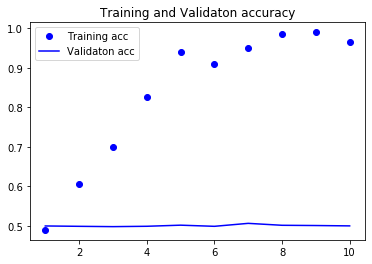

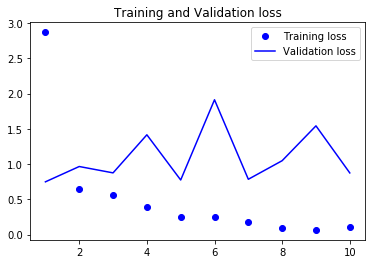

In [60]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validaton acc')
plt.title('Training and Validaton accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### 不使用预训练的词嵌入情况下训练相同的模型
* 就是在第一层Embedding层上不加入GloVe词嵌入矩阵，代表没有向量和单词相关

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


/home/wukong/anaconda3/envs/deeplearning/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6950 - acc: 0.5250 - val_loss: 0.6938 - val_acc: 0.4983
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5153 - acc: 0.9800 - val_loss: 0.6983 - val_acc: 0.4963
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2989 - acc: 0.9950 - val_loss: 0.7044 - val_acc: 0.4991
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1338 - acc: 1.0000 - val_loss: 0.7174 - val_acc: 0.4964
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0630 - acc: 1.0000 - val_loss: 0.7168 - val_acc: 0.4994
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0325 - acc: 1.0000 - val_loss: 0.7304 - val_acc: 0.4961
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0178 - acc: 1.0000 - val_loss: 0.7378 - val_acc: 0.4949
Epoch 8/10
200/200 [========

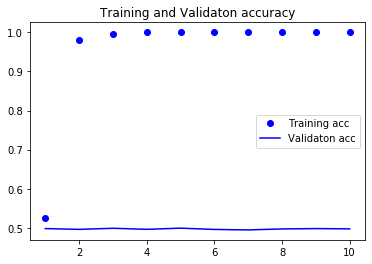

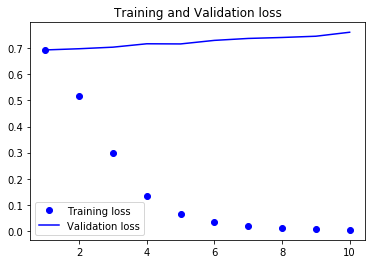

In [61]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validaton acc')
plt.title('Training and Validaton accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### 在测试集上评估模型

In [66]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 32us/step


[0.8744932141685486, 0.49404001235961914]